# Preliminary Experiment for _AKU_

Bernhard Bermeitinger, bernhard.bermeitinger@uni-passau.de

In [1]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(keras.__version__)

1.13.0-rc0
2.2.4-tf


In [2]:
import os
import math
from glob import glob
import random
import re
from collections import Counter
import shutil

import subprocess

In [6]:
import pandas as pd
import numpy as np

import joblib
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

In [7]:
LABEL = 'gar'

from_env = os.getenv('LABEL')
if from_env is not None:
    LABEL = from_env

if LABEL not in ['gar', 'moe']:
    print("wrong label: ", LABEL)

In [8]:
NUM_GPUS = int(str(subprocess.check_output(["nvidia-smi", "-L"])).count('UUID'))

if NUM_GPUS < 1:
    print("NO GPU FOUND, WILL USE CPU")
    NUM_GPUS = 1

else:
    print("Using {} GPUs".format(NUM_GPUS))

Using 1 GPUs


In [9]:
INDIR = os.path.join("/data", "AKU")
OUTDIR = os.path.join("/output")

# Data Reading

In [26]:


def _parse_function(example):
    keys_to_features = {
        'image_data': tf.FixedLenFeature((), tf.string, default_value=""),
        'label': tf.FixedLenFeature((), tf.int64, default_value=tf.zeros([], dtype=tf.int64))
    }
    parsed = tf.parse_single_example(example, keys_to_features)
    
    image = tf.image.decode_jpeg(parsed['image_data'])
    image = tf.image.resize(image, (128, 128))
    image = tf.reshape(image, (128, 128, 1))
    
    label = parsed['label']
    
    return {'image_data': image}, label


dataset = tf.data.TFRecordDataset([os.path.join(INDIR, "data_{}.tfrecord".format(LABEL))])
dataset = dataset.map(_parse_function)
dataset = dataset.shuffle(buffer_size=10000)
dataset = dataset.batch(32)

In [15]:
LBL_BIN = LabelBinarizer()
LBL_BIN.fit(sorted(df.label.unique()))
joblib.dump(LBL_BIN, os.path.join(OUTDIR, 'LBL-BIN_{}.pkl'.format(LABEL)), compress=True)

['/output/LBL-BIN_gar.pkl']

In [16]:
def load_image(image_path, size, channels=1, augment=True):
    if channels == 3:
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif channels == 1:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    
    if augment:
        rows, cols = img.shape[:2]
        # random rotation
        M = cv2.getRotationMatrix2D((cols/2, rows/2), np.random.randint(-7, 7), 1)
        img = cv2.warpAffine(img, M, (cols, rows), borderValue=0)

        # random shear
        M = np.float32([
            [1, 0, np.random.uniform(-cols * 0.07, cols * 0.07)],
            [0, 1, np.random.uniform(-rows * 0.07, rows * 0.07)]])
        img = cv2.warpAffine(img, M, (cols, rows), borderValue=0)

        # random zoom
        M = np.float32([
            [1+np.random.uniform(0.0, 0.07), 0, 0],
            [0, 1+np.random.uniform(0.0, 0.07), 0]
        ])
        img = cv2.warpAffine(img, M, (cols, rows), borderValue=0)
    
    img = img.reshape(*size, channels)
    img = img.astype('float32')
    
    img /= 255.0
    
    return img

image    /data/AKU/komplett/converted/GarA1_Moe33_HT_pB...
label                                               gar_a1
Name: 390, dtype: object


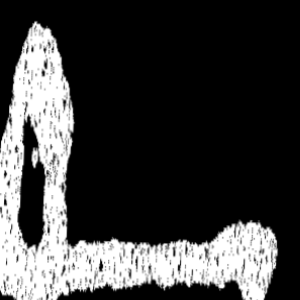

In [17]:
ex = df.sample(1).iloc[0]
print(ex)
img = load_image(ex.image, (300, 300), 1, augment=True)
Image.fromarray((np.array(img[:, :, 0]) * 255).astype(np.uint8))

In [18]:
BATCH_SIZE = 256 * NUM_GPUS # smaller batch size: more updates
IMAGE_SIZE = (224, 224)

In [19]:
class_weight = sklearn.utils.compute_class_weight(
    class_weight='balanced',
    classes=LBL_BIN.classes_,
    y=train_df.label
)

In [20]:
class AKUSequence(keras.utils.Sequence):
    
    def __init__(self, df, image_size=IMAGE_SIZE, channels=3, batch_size=64, mode='train'):
        self.image_size = image_size
        self.channels = channels
        
        self.batch_size = batch_size
        if mode not in ['train', 'test']:
            raise ValueError("mode must be 'train' or 'test'")
        self.mode = mode
        
        self.images = df.image
        self.labels = df.label
        
        self.indexes = range(len(self.images))
    
    def __len__(self):
        return int(np.ceil(len(self.indexes) / float(self.batch_size)))
    
    def on_epoch_end(self):
        self.indexes = range(len(self.images))
        if self.mode == 'train':
            self.indexes = random.sample(self.indexes, k=len(self.indexes))
            
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        batch_labels = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]
        return LBL_BIN.transform(batch_labels)
    
    def get_batch_images(self, idx):
        batch_images = self.images[idx * self.batch_size : (idx + 1) * self.batch_size]
        images = np.empty((len(batch_images), *self.image_size, self.channels))
        for i, img in enumerate(batch_images):
            images[i] = load_image(
                img,
                size=self.image_size, channels=self.channels,
                augment=self.mode == 'train'
            )
        
        return images
    
    def __getitem__(self, idx):
        batch_x = self.get_batch_images(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_x, batch_y

In [21]:
len(LBL_BIN.classes_)

52

In [22]:
def print_report(y_true, y_pred):
    print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred)))
    print(classification_report(y_true, y_pred))

create model

In [53]:
BATCH_SIZE = 256
IMAGE_SIZE = (128, 128)
NUM_CHANNELS = 1
NUM_CLASSES = len(LBL_BIN.classes_)

s_train = AKUSequence(train_df, IMAGE_SIZE, NUM_CHANNELS, BATCH_SIZE, mode='train')
s_test = AKUSequence(test_df, IMAGE_SIZE, NUM_CHANNELS, BATCH_SIZE, mode='test')

class_weight = sklearn.utils.compute_class_weight(
    class_weight='balanced',
    classes=train_df.label.unique(),
    y=train_df.label
)

inputs = keras.layers.Input(shape=(*IMAGE_SIZE, NUM_CHANNELS))

# input conv
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = keras.layers.MaxPool2D((2, 2))(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = keras.layers.MaxPool2D((2, 2))(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(len(LBL_BIN.classes_), activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=outputs)


model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.SGD(),
    metrics=[keras.metrics.categorical_accuracy, keras.metrics.top_k_categorical_accuracy]
)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 61, 61, 64)        36928     
__________

In [54]:
tb_dir = os.path.join(OUTDIR, 'tensorboard', 'AKU-128-C32C32PC64C64PPD512-adadelta_{}'.format(LABEL))
if os.path.isdir(tb_dir):
    shutil.rmtree(tb_dir)

os.makedirs(tb_dir, exist_ok=True)

tb = keras.callbacks.TensorBoard(
    log_dir=tb_dir, 
    batch_size=BATCH_SIZE,
    write_images=True
)

h = model.fit_generator(
    generator=s_train,
    validation_data=s_test,
    epochs=1000,
    use_multiprocessing=True,
    workers=4,
    class_weight=class_weight,
    callbacks=[tb, keras.callbacks.EarlyStopping(patience=50)]
)

Epoch 1/1000
11/11 [==============================] - 9s 793ms/step - loss: 3.9559 - categorical_accuracy: 0.0154 - top_k_categorical_accuracy: 0.0697 - val_loss: 3.9508 - val_categorical_accuracy: 0.0104 - val_top_k_categorical_accuracy: 0.1103
Epoch 2/1000
11/11 [==============================] - 3s 278ms/step - loss: 3.9535 - categorical_accuracy: 0.0157 - top_k_categorical_accuracy: 0.0793 - val_loss: 3.9492 - val_categorical_accuracy: 0.0179 - val_top_k_categorical_accuracy: 0.1058
Epoch 3/1000
11/11 [==============================] - 3s 317ms/step - loss: 3.9512 - categorical_accuracy: 0.0189 - top_k_categorical_accuracy: 0.0978 - val_loss: 3.9476 - val_categorical_accuracy: 0.0119 - val_top_k_categorical_accuracy: 0.0894
Epoch 4/1000
11/11 [==============================] - 2s 208ms/step - loss: 3.9478 - categorical_accuracy: 0.0320 - top_k_categorical_accuracy: 0.1423 - val_loss: 3.9460 - val_categorical_accuracy: 0.0119 - val_top_k_categorical_accuracy: 0.1043
Epoch 5/1000
11/

In [56]:
print("VAL_ACC:", h.history['val_categorical_accuracy'][-1])
print("VAL_TOP_5_ACC:", h.history['val_top_k_categorical_accuracy'][-1])

VAL_ACC: 0.08792846470005289
VAL_TOP_5_ACC: 0.3666169917885486


In [ ]:
y_true = np.empty((len(test_df), len(LBL_BIN.classes_)))
y_pred = np.empty((len(test_df), len(LBL_BIN.classes_)))

for i in tqdm(range(len(s_test))):
    xb, yb = s_test[i]
    y_true[i * BATCH_SIZE : i * BATCH_SIZE + BATCH_SIZE, :] = yb
    y_pred[i * BATCH_SIZE : i * BATCH_SIZE + BATCH_SIZE, :] = model.predict_on_batch(xb)

In [ ]:
print_report(LBL_BIN.inverse_transform(y_true), LBL_BIN.inverse_transform(y_pred))